In [206]:
# DATA:  Since the X has 321 features and 48 samples. Y has 16 target classes with 3 samples/subject
#        making is 16 x 3 = 48 samples. 

# AIM:   The aim is to be able to classify data based on 16 target classes (16 subjects).

# ISSUE: When I split the data between test/train, the minimum split needed is 33%/67% as 33% corresonds to
#        1 sample/subject in the test data, leaving only 2 samples/subject for training, which is not enough.

#        Only 1 test sample/class      - completely unreliable evaluation.
#        Only 2 train samples/class    - impossible to learn patterns.
#        Even after oversampling, there's not enough diversity in the synthetic samples.
#        Terrible model performance - 0.0 recall/precision for many of the 16 classes.

# SOLUTION: 1. Collect more data (NOT POSSIBLE).
#           2. Reduce number of classes by combining similar classes to have fewer, more populated classes.
#           3. Skip the evaluation metrics - just explore the data!

# HERE: Exploring SOLUTION 2, using Unsupervised Machine Learning Methods (using data that was previously cleaned)
#                             Best                      Pros                       Cons
#       - DBSCAN:             Discover naural groups    k is not needed            Needs eps: fail on sparse data
#       - Hierarchical:       Interpretability          Dendrogram/Deterministic   Needs k: certain cluster shape assumed
#       - KMeans:             Roughly known groups      Fast/Simple/Stable         Needs k: spherical cluster shape assumed 
                


In [207]:
# Import Libs
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, fcluster

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pprint

In [208]:
# Load the data
df = pd.read_csv('gait_final_output_updated.csv')
print(f"df.shape: {df.shape}")
df.sample(1)


df.shape: (48, 322)


,Speed_R1,Variability_R1,Symmetry_R1,HeelPressTime_R1,CycleTime_R1,Cadence_R1,Posture_R1,Oscillation_R1,Loading_R1,FootPress_R1,Thrust_R1,DoubleSupport_R1,StepLength_R1,StepSpeed_R1,PeakAngleSpeed_R1,MaxSwingSpeed_R1,RotationAngle_R1,StepAngle_R1,LiftAngle_R1,SwingWidth_R1,3DPathLength_R1,MaxHeelHeight_R1,MaxFingerTipHeight_R1,MinFingerTipHeight_R1,P25_R1,P26_R1,P27_R1,P28_R1,P29_R1,P30_R1,P31_R1,P32_R1,P33_R1,P34_R1,P35_R1,P36_R1,P37_R1,P38_R1,P39_R1,P40_R1,...,P69_R3,P70_R3,P71_R3,P72_R3,P73_R3,P74_R3,P75_R3,P76_R3,P77_R3,P78_R3,P79_R3,P80_R3,P81_R3,P82_R3,P83_R3,P84_R3,P85_R3,P86_R3,P87_R3,P88_R3,P89_R3,P90_R3,P91_R3,P92_R3,P93_R3,P94_R3,P95_R3,P96_R3,P97_R3,P98_R3,P99_R3,P100_R3,P101_R3,P102_R3,P103_R3,P104_R3,P105_R3,P106_R3,P107_R3,Subject_ID_Y
12,1.45,0.0,0.9,1.029,1.025,0.995,0.995,0.154,0.139,0.054,0.064,0.945,0.71,2.175,1.79,1.004,0.996,14.985,13.511,117.95,118.53,120.6,120.6,9.58,11.87,6.37,7.55,55.17,67.04,126.98,169.01,1.0,1.0,8.12,10.02,1.397,1.449,1.453,1.49,0.205,...,0.089,0.018,0.016,0.02,0.02,0.05,0.045,0.131,0.117,1.067,0.937,0.055,0.053,0.056,0.054,0.01,0.013,0.01,0.017,0.016,0.013,0.072,0.076,1.042,0.96,0.17,0.181,0.173,0.186,0.026,0.03,0.026,0.024,0.029,0.035,0.215,0.238,0.941,1.063,4


In [209]:
# Split X, y
y = df['Subject_ID_Y']
X = df.drop(columns=['Subject_ID_Y'], axis='column')
print(f"X.shape: {X.shape} | y.shape: {y.shape}")


X.shape: (48, 321) | y.shape: (48,)


In [210]:
# Calculate class centroids
class_centroid, class_label = [], []

for cls in np.unique(y):
    centroid = X[y==cls].mean(axis='rows')
    class_centroid.append( centroid ) 
    class_label.append( cls )

# Convert class_centroid from list to array
class_centroid = np.array( class_centroid )
print(f"Number of class centroids: {len(class_centroid)}, should be same as number of unique classes: {len(np.unique(y))}")
print(f"Shape of class_centroid: {class_centroid.shape}")

Number of class centroids: 16, should be same as number of unique classes: 16
Shape of class_centroid: (16, 321)



------------------------------------------------------------
METHOD 1: DBSCAN
------------------------------------------------------------

= n_neighbors: 3 =

 distances.shape:(16, 3), indices.shape:(16, 3)

distances:
 [[0.00000000e+00 1.25659471e+02 1.40840439e+02]
 [2.15791864e-05 1.22064209e+02 1.62224369e+02]
 [0.00000000e+00 2.39970642e+02 2.50737934e+02]
 [3.05175781e-05 1.95138271e+02 1.96003560e+02]
 [0.00000000e+00 7.95633689e+02 8.01720102e+02]
 [0.00000000e+00 1.22064209e+02 1.62803889e+02]
 [5.28579958e-05 1.11275417e+03 1.12499727e+03]
 [3.73762473e-05 1.45413704e+02 1.72249185e+02]
 [0.00000000e+00 1.40840439e+02 1.60346261e+02]
 [0.00000000e+00 8.87129329e+02 9.00609730e+02]
 [0.00000000e+00 3.87327808e+02 3.87474103e+02]
 [0.00000000e+00 1.25659471e+02 1.45413704e+02]
 [0.00000000e+00 1.43410391e+04 1.43567535e+04]
 [2.15791864e-05 1.49892157e+02 1.72172558e+02]
 [3.05175781e-05 1.70301275e+02 1.72172558e+02]
 [5.28579958e-05 1.88921375e+02 2.06485565e+02]]

distanes

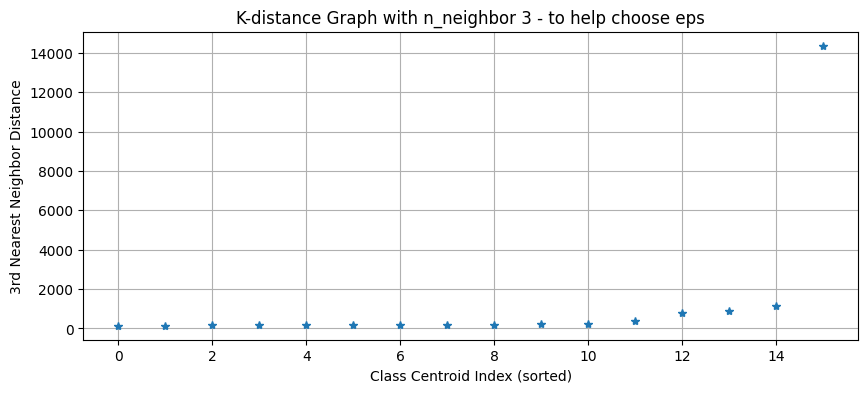

In [211]:
print("\n"+"-"*60)
print("METHOD 1: DBSCAN")
print("-"*60)

# Find optimal eps using k-distance graphs
from sklearn.neighbors import NearestNeighbors
n_neighbor = 3 # results do not change for 3, 4, 5

print(f"\n= n_neighbors: {n_neighbor} =")
neighbors          = NearestNeighbors( n_neighbors=n_neighbor )
neighbors_fit      = neighbors.fit( class_centroid )
distances, indices = neighbors_fit.kneighbors( class_centroid )
print(f"\n distances.shape:{distances.shape}, indices.shape:{indices.shape}")
print ("\ndistances:\n", distances ) 

# Selects the last column from the distances array, which contains the distance to the farthest 
# of the 3 nearest neighbors (the 3rd nearest neighbor) for each point
print("\ndistanes[:,-1]:\n", distances[:, -1] )
distances_sorted = np.sort( distances[:, -1] )
print("\nsorted distances[:,-1]:\n", distances_sorted )
print("\nsorted distances[:,-1] shape:\n", distances_sorted.shape )

# distances is a 2D array of shape (n_samples, n_neighbors), so for each point, we get distances to its 3 nearest neighbors.
# The columns represent the distance to the 1st, 2nd, 3rd nearest neighbors, in increasing order (since kneighbors returns sorted distances)

# By using the distance to the k-th nearest neighbor (here, k=3), we get a measure of local density:
# If the distance to the 3rd nearest neighbor is small => the point is in a dense region
# If it's large => the point is in a sparse region or is an outlier

# When we plot these sorted distances, to get the k-distance graph. 
# Points on the left (low index) have small distances to their 3rd neighbor (dense regions), 
# while points on the right have large distances (sparse regions or outliers). 
# The "elbow" where distances start increasing sharply indicates a good eps value (boundary between dense clusters and noise).

# PLOT
plt.figure( figsize=(10,4) )
plt.plot(distances_sorted, '*')
plt.ylabel('3rd Nearest Neighbor Distance')
plt.xlabel('Class Centroid Index (sorted)')
plt.title(f'K-distance Graph with n_neighbor {n_neighbor} - to help choose eps' )
plt.grid(True)
plt.show( )


In [212]:
# Look for maximum curvature (elbow)
diffs       = np.diff(distances_sorted)
elbow_idx   = np.argmax(diffs)
optimal_eps = distances_sorted[elbow_idx]

print(f"\nLargest jump at index {elbow_idx}: {optimal_eps:.2f} => {distances_sorted[elbow_idx+1]:.2f}")
print(f"Jump size: {diffs[elbow_idx]:.2f}")

# Use distances before the elbow for eps range (aotomatically excludes outlier)
main_distances = distances_sorted[0:elbow_idx+1]
main_distances

# Calculate stats on main group
min_main    = main_distances.min()
max_main    = main_distances.max()
mean_main   = main_distances.mean()
median_main = np.median( main_distances )

print(f"\nDistances from the main group only:")
print(f"min:{min_main:.1f}, max:{max_main:.1f}, mean:{mean_main:.1f}, median:{median_main:.1f}")

# Automatic identification of 10 eps values to explore. Try eps values from little below median to slightly above max.
eps_range = np.linspace(median_main*0.75, max_main*1.25, 10)
print(f"\nAutogenerated eps values to explore: {eps_range}")



Largest jump at index 14: 1125.00 => 14356.75
Jump size: 13231.76

Distances from the main group only:
min:140.8, max:1125.0, mean:343.8, median:172.2

Autogenerated eps values to explore: [ 129.18688884  271.082411    412.97793316  554.87345533  696.76897749
  838.66449965  980.56002181 1122.45554397 1264.35106613 1406.24658829]


In [225]:
# Now try DBSCAN on 'CENTROIDS' with optimal eps values found in the previous step.
# Clustering the centroids (representative points of each class) rather than all individual data points. 
# This is a preprocessing step to reduce noise or computational complexity before applying DBSCAN.

class_labels = np.unique(y)  # Add this line!
print(f"Number of classes: {len(class_labels)}")
print(f"Class labels: {class_labels}")
print(f"Number of centroids: {len(class_centroids)}")

best_dbscan     = None
best_n_clusters = 0 # accounts for the possibility of no valid clusters (all noise)
best_eps        = None
best_score      = -1
best_noise      = None
all_results = []

print("\n")
print("Testing eps values:")
for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=2)
    labels = dbscan.fit_predict(class_centroid)
    print(f"Cluster labels:{labels}")

    n_clusters = len(set(labels)) - (1 if -1 in labels  else 0) # remove noise -1 and then count clusters
    n_noise    = list(labels).count(-1)                         # count noise -1    
    print(f"For eps={eps:.1f}, clusters={n_clusters}, noise={n_noise}")

    # SKIP USELESS CASES
    if n_clusters <= 1 or n_clusters >= len(class_centroid)-1:
        print(f"---SKIPPING: For eps={eps:.1f}, clusters={n_clusters}, noise={n_noise}")
        continue

    # Simple score: more clusters is better, noise is bad.
    score = n_clusters - (n_noise*2)
    print(f"For eps={eps:.1f}, clusters={n_clusters}, noise={n_noise}, score={score}")

    all_results.append({
        'eps':        eps,
        'n_clusters': n_clusters,
        'n_noise':    n_noise,
        'score':      score, # DO NOT USE abs(score) - it's wrong - it chooses the worst cluster! 
        'labels':     labels.copy(),
    })    
    
    
    print('-------------')
    
print("==========================")    
print("all_results:", all_results) 
print("==========================")

Number of classes: 16
Class labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Number of centroids: 0


Testing eps values:
Cluster labels:[ 0  1 -1 -1 -1  1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1]
For eps=129.2, clusters=2, noise=12
For eps=129.2, clusters=2, noise=12, score=-22
-------------
Cluster labels:[ 0  0  0  0 -1  0 -1  0  0 -1 -1  0 -1  0  0  0]
For eps=271.1, clusters=1, noise=5
---SKIPPING: For eps=271.1, clusters=1, noise=5
Cluster labels:[ 0  0  0  0 -1  0 -1  0  0 -1  0  0 -1  0  0  0]
For eps=413.0, clusters=1, noise=4
---SKIPPING: For eps=413.0, clusters=1, noise=4
Cluster labels:[ 0  0  0  0 -1  0 -1  0  0 -1  0  0 -1  0  0  0]
For eps=554.9, clusters=1, noise=4
---SKIPPING: For eps=554.9, clusters=1, noise=4
Cluster labels:[ 0  0  0  0 -1  0 -1  0  0 -1  0  0 -1  0  0  0]
For eps=696.8, clusters=1, noise=4
---SKIPPING: For eps=696.8, clusters=1, noise=4
Cluster labels:[ 0  0  0  0  0  0 -1  0  0 -1  0  0 -1  0  0  0]
For eps=838.7, clusters=1, noise=3
---SKIPPING: Fo

In [260]:
# Pick the best result
if not all_results:
    print("\n✗ DBSCAN failed - no valid results found")
    y_merged_dbscan = None
else:
    best = max(all_results, key=lambda x: x['score'])
    
    # Check if best score is negative
    if best['score'] < 0:
        print(f"\n DBSCAN failed - best score is {best['score']:.1f} (too much noise)")
        print(f"Best attempt: {best['n_clusters']} clusters with {best['n_noise']} noise points")
        print("  -> Falling back to Hierarchical/K-Means")
        y_merged_dbscan = None
    else:
        print(f"\nBest DBSCAN: eps={best['eps']:.2f}, {best['n_clusters']} clusters, {best['n_noise']} noise, score={best['score']:.1f}")
        
        # Handle noise points
        dbscan_labels = best['labels'].copy()
        noise_mask = dbscan_labels == -1
        print('\n')
        print('dbscan_labels:', dbscan_labels)
        print('noise_mask:', noise_mask)
        print('noise_mask.any(): ', noise_mask.any())
        print('\n')
        
        if noise_mask.any():
            print(f"  Assigning {noise_mask.sum()} noise points to nearest clusters...")
            from scipy.spatial.distance import cdist
            
            # Get valid cluster IDs
            valid_clusters = sorted( [int(c) for c in set(dbscan_labels) if c != -1] )
            print("\n")
            print("valid_clusters: ", valid_clusters)
            print("\n")
            
            # Build cluster centers
            cluster_centers_list = []
            for cid in valid_clusters:
                mask = (dbscan_labels == cid)
                cluster_points = class_centroid[mask]  
                center = cluster_points.mean(axis=0)
                cluster_centers_list.append(center)

            cluster_centers = np.array(cluster_centers_list)            
            
            # Assign noise to nearest cluster
            for idx in np.where(noise_mask)[0]:
                idx = int(idx)
                point = class_centroid[idx].reshape(1, -1)  
                dists = cdist(point, cluster_centers)[0]
                nearest_cluster_idx = int(np.argmin(dists))
                dbscan_labels[idx] = valid_clusters[nearest_cluster_idx]
        
        # Create mapping        
        print(f"Debug: class_labels       = {class_labels}")
        print(f"Debug: class_labels type  = {type(class_labels)}")
        print(f"Debug: len(class_labels)  = {len(class_labels)}")
        print(f"Debug: dbscan_labels      = {dbscan_labels}")
        print(f"Debug: len(dbscan_labels) = {len(dbscan_labels)}")
        
        class_mapping_dbscan = {int(old): int(new) for old, new in zip(class_labels, dbscan_labels)}
        print("\n")
        print("class_mapping_dbscan:", class_mapping_dbscan)
        print("\n")
        y_merged_dbscan      = pd.Series(y).map(class_mapping_dbscan).values
        
        print(f"\nMapping: {class_mapping_dbscan}")
        print(f"Distribution: \n{pd.Series(y_merged_dbscan).value_counts().sort_index()}")
        # Cluster 0: 30 samples
        # Cluster 1: 18 samples

        # Show which original classes were merged into each final cluster
        print("\n")
        print(f"Cluster Composition:")

        print("class_mapping_dbscan.values():", class_mapping_dbscan.values())
        print("--")
        for final_cluster in sorted(set(class_mapping_dbscan.values())):   
            print("class_mapping_dbscan.items(): ", class_mapping_dbscan.items()) 
            original_classes = []
            for orig, new in class_mapping_dbscan.items():
                if new == final_cluster:
                    original_classes.append(orig)            
            print(f"Final Cluster {final_cluster}: merged {len(original_classes)} original classes => {original_classes}")
            print('--')
            


Best DBSCAN: eps=129.19, 2 clusters, 12 noise, score=22.0


dbscan_labels: [ 0  1 -1 -1 -1  1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1]
noise_mask: [False False  True  True  True False  True  True  True  True  True False
  True  True  True  True]
noise_mask.any():  True


  Assigning 12 noise points to nearest clusters...


valid_clusters:  [0, 1]


Debug: class_labels       = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Debug: class_labels type  = <class 'numpy.ndarray'>
Debug: len(class_labels)  = 16
Debug: dbscan_labels      = [0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1]
Debug: len(dbscan_labels) = 16


class_mapping_dbscan: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1}



Mapping: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1}
Distribution: 
0    30
1    18
Name: count, dtype: int64


Cluster Composition:
class_mapping_dbscan.values(): dict_values([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,